In [105]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [106]:
train_img_path  = "../data/Training-Dataset/Images/"
train_mask_path = "../data/Training-Dataset/Masks-Ideal/"
validation_img_path  = "../data/Validation-Dataset/Images/"
validation_mask_path = "../data/Validation-Dataset/Masks-Ideal/"

In [107]:
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images[filename.split('.')[0]] = img  #remove extension from file name
    return images

In [108]:
images = load_images_from_folder(train_img_path)
masks  = load_images_from_folder(train_mask_path)

valid_images = load_images_from_folder(validation_img_path)
valid_masks  = load_images_from_folder(validation_mask_path)

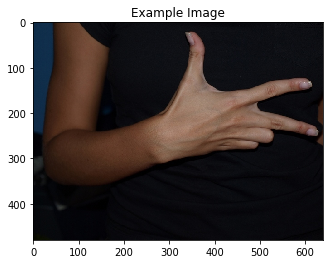

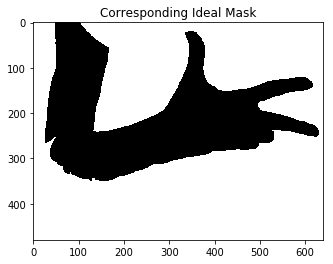

In [109]:
plt.title("Example Image")
plt.imshow(cv2.cvtColor(images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask")
plt.imshow(cv2.cvtColor(masks['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()

In [110]:
def skinDetection(image, mask, value = 255):
    mask_skin = mask != 0
    img = image.copy()
    img[mask_skin]= value
    return img

In [111]:
skin_images = {}
for key in images.keys():
    skin_images[key] = skinDetection(images[key], masks[key])

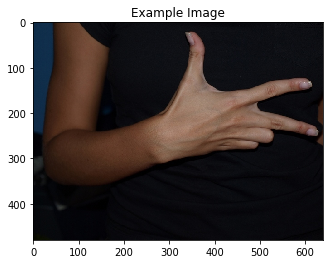

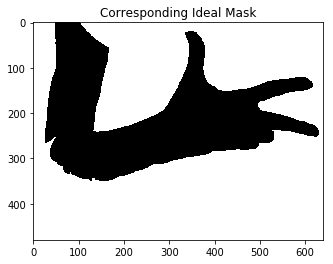

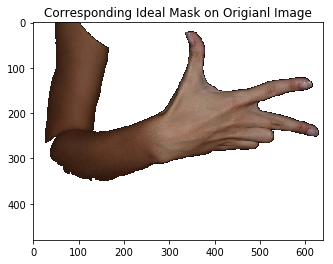

In [112]:
plt.title("Example Image")
plt.imshow(cv2.cvtColor(images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask")
plt.imshow(cv2.cvtColor(masks['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask on Origianl Image")
plt.imshow(cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()

In [113]:
def histogramCharacterization(image, channels, min_value, max_value, color_space, xbins, ybins = 0):
    if ybins == 0:
        ybins = xbins
    
    colors = ["r", "g", "b"]
    if color_space == "RGB":
        channel_histograms = []
        for wanted_channel in channels:
            img = image[:,:,wanted_channel]

            hist = cv2.calcHist([img], [0] , None, [xbins], [min_value, max_value])
            channel_histograms.append(hist)

            # plot the histogram
            #plt.plot(hist, color = colors[wanted_channel])
            #plt.xlim([0, 256])
        return channel_histograms[0],channel_histograms[1],channel_histograms[2]
   
    elif color_space == "YCrCb":
        minCr = image[:,:,1].min()
        maxCr = image[:,:,1].max()
        minCb = image[:,:,2].min()
        maxCb = image[:,:,2].max()
        hist = cv2.calcHist([image[:,:,1], image[:,:,2]], [0,1], None, [xbins, ybins], [min_value, max_value,min_value, max_value,])
        return hist, minCr, maxCr, minCb, maxCb

In [114]:
histR, histG, histB = histogramCharacterization(cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB), [0,1,2] , 0, 255, "RGB", 255)

In [115]:
bins = 30
binsRGB = 255
channels  = [0,1,2]
min_value = 0
max_value = 255

global_min_xEdges = 999
global_max_xEdges = 0
global_min_yEdges = 999
global_max_yEdges = 0
bidimensional_histogram_CrCb = [[0 for i in range(bins)] for j in range(bins)]

bidimensional_histogram_R = [0 for i in range(binsRGB)]
bidimensional_histogram_G = [0 for i in range(binsRGB)]
bidimensional_histogram_B = [0 for i in range(binsRGB)]

In [116]:
def AddHistogramCrCb(modelHist, summingHist, summingMinXEdge, summingMaxXEdge, summingMinYEdge, summingMaxYEdge):
    modelHist += summingHist
    global_min_xEdges_ = min(global_min_xEdges, summingMinXEdge)
    global_max_xEdges_ = max(global_max_xEdges, summingMaxXEdge)
    global_min_yEdges_ = min(global_min_yEdges, summingMinYEdge)
    global_max_yEdges_ = max(global_max_yEdges, summingMaxYEdge)    
    return modelHist, global_min_xEdges_, global_max_xEdges_, global_min_yEdges_, global_max_yEdges_

In [117]:
def pixelClassification(image, channels, stats, threshold):
    n,m,_ = image.shape
    image_copy = image.copy()*False
    
    for k in range(channels):
        true_values = (stats[k] + threshold - stats[k]-threshold <= image[:,:,k]) == (image[:,:,k] <= stats[k][0] + stats[k][1])
        image_copy[true_values,k] = True
    
    return image_copy[:,:,0] & image_copy[:,:,1] & image_copy[:,:,2]  #bitwise operator: AND  applied to channels  

In [118]:
def AddHistogram(modelHist, summingHist, summingMinXEdge, summingMaxXEdge, summingMinYEdge, summingMaxYEdge):
    modelHist += summingHist
    global_min_xEdges_ = min(global_min_xEdges, summingMinXEdge)
    global_max_xEdges_ = max(global_max_xEdges, summingMaxXEdge)
    global_min_yEdges_ = min(global_min_yEdges, summingMinYEdge)
    global_max_yEdges_ = max(global_max_yEdges, summingMaxYEdge)    
    return modelHist, global_min_xEdges_, global_max_xEdges_, global_min_yEdges_, global_max_yEdges_

In [154]:
#YCRCB
for key in skin_images.keys():
    image = skin_images[key].copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    histogramCrCb, minCr, maxCr, minCb, maxCb = histogramCharacterization(image, [0,1], 100, 200,"YCrCb", bins)
    bidimensional_histogram_CrCb, global_min_xEdges, global_max_xEdges, global_min_YEdges, global_max_YEdges = AddHistogram(bidimensional_histogram_CrCb, histogramCrCb,minCr, maxCr, minCb, maxCb)

bidimensional_histogram_CrCb /= len(skin_images)
#bidimensional_histogram_CrCb = cv2.normalize(bidimensional_histogram, bidimensional_histogram, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).astype('float32')

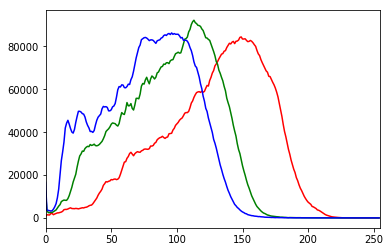

In [133]:
#RGB
for key in skin_images.keys():
    image = skin_images[key].copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    histR, histG, histB = histogramCharacterization(image, [0,1,2], 0, 255,"RGB", binsRGB)
    #bidimensional_histogram_R, bidimensional_histogram_G, bidimensional_histogram_B = AddHistogramRGB(bidimensional_histogram_R,bidimensional_histogram_G,bidimensional_histogram_B, histR, histG, histB)
    bidimensional_histogram_R += histR.flatten()
    bidimensional_histogram_G += histG.flatten()
    bidimensional_histogram_B += histB.flatten()
    
    
#bidimensional_histogram_R /= len(skin_images)
#bidimensional_histogram_R = cv2.normalize(bidimensional_histogram_R, bidimensional_histogram_R, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).astype('float32')
#bidimensional_histogram_G = cv2.normalize(bidimensional_histogram_G, bidimensional_histogram_G, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).astype('float32')
#bidimensional_histogram_B = cv2.normalize(bidimensional_histogram_B, bidimensional_histogram_B, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).astype('float32')

plt.plot(bidimensional_histogram_R, color = "r")
plt.plot(bidimensional_histogram_G, color = "g")
plt.plot(bidimensional_histogram_B, color = "b")
plt.xlim([0,binsRGB])

plt.show()


In [134]:
sumR = 0
sumB = 0
sumG = 0 
for i in range(0,255):
    sumR += i * bidimensional_histogram_R[i]
    sumG += i * bidimensional_histogram_G[i]
    sumB += i * bidimensional_histogram_B[i]
    
sumR /= sum(bidimensional_histogram_R)
sumG /= sum(bidimensional_histogram_G)
sumB /= sum(bidimensional_histogram_B)


sumR, sumG, sumB

(128.09879775602923, 93.14669557119132, 77.54419675561464)

In [137]:
'''
threshold = 2
stats = [sumR, sumG, sumB]

predict_mask = np.zeros(shape=(len(test),len(test[0])),dtype="uint8")
for i in range(0,len(test)):
    for j in range(0,len(test[0])):
        if test[i,j,0] >= stats[0] - threshold and test[i,j,0] <= stats[0] + threshold:
             if test[i,j,1] >= stats[1] - threshold and test[i,j,1] <= stats[1] + threshold:
                     if test[i,j,2] >= stats[2] - threshold and test[i,j,2] <= stats[2] + threshold:
                            predict_mask[i,j] = 1
                            
plt.imshow(predict_mask)
'''

'\nthreshold = 2\nstats = [sumR, sumG, sumB]\n\npredict_mask = np.zeros(shape=(len(test),len(test[0])),dtype="uint8")\nfor i in range(0,len(test)):\n    for j in range(0,len(test[0])):\n        if test[i,j,0] >= stats[0] - threshold and test[i,j,0] <= stats[0] + threshold:\n             if test[i,j,1] >= stats[1] - threshold and test[i,j,1] <= stats[1] + threshold:\n                     if test[i,j,2] >= stats[2] - threshold and test[i,j,2] <= stats[2] + threshold:\n                            predict_mask[i,j] = 1\n                            \nplt.imshow(predict_mask)\n'

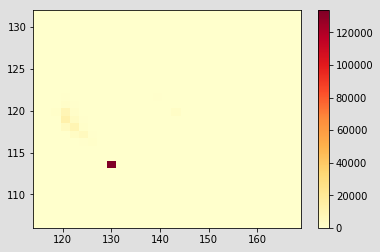

In [160]:
xedges = np.linspace(global_min_xEdges, global_max_xEdges, bins)
yedges = np.linspace(global_min_YEdges, global_max_YEdges, bins)

X, Y = np.meshgrid(xedges, yedges)

fig = plt.figure()
im = plt.pcolormesh(X, Y, bidimensional_histogram_CrCb, cmap = "YlOrRd")
fig.patch.set_facecolor('#E0E0E0')
plt.colorbar(im)
plt.show()

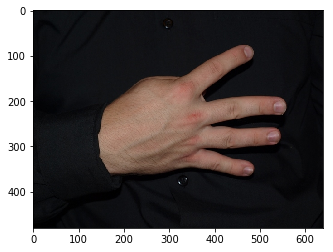

In [146]:
test = cv2.cvtColor(valid_images['4_P_hgr1_id08_1'], cv2.COLOR_BGR2YCrCb)
test_mask = cv2.cvtColor(valid_masks['4_P_hgr1_id08_1'], cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(test, cv2.COLOR_YCrCb2RGB), cmap = "gray")

In [125]:
predict_min_cr = 130.86909618973448 - 9.778013334580802
predict_max_cr = 130.86909618973448 + 9.778013334580802
predict_min_cb = 126.97045599406536 - 8.435690975078709
predict_max_cb = 126.97045599406536 + 8.435690975078709

In [157]:
predict_min_cr = 117
predict_max_cr = 130
predict_min_cb = 12
predict_max_cb = 122

In [126]:
'''
predict_mask = np.zeros(shape=(len(test),len(test[0])),dtype="uint8")
for i in range(0,len(test)):
    for j in range(0,len(test[0])):
        mask = np.zeros(shape=(len(test),len(test[0])),dtype="uint8")
        mask[i,j] = 1        
        pixel_hist = cv2.calcHist([test[:,:,1], test[:,:,2]], [0,1], mask, [bins,bins], [0,255,0,255]) 
        value = pixel_hist.argmax()
        x = value % bins
        y = int(value / bins)
        if bidimensional_histogram_CrCb[x][y] > 0.0005:
            predict_mask[i,j] = 1
        else:
            predict_mask[i,j] = 0
        #metric_val = cv2.compareHist(bidimensional_histogram, pixel_hist, cv2.HISTCMP_INTERSECT)
'''

'\npredict_mask = np.zeros(shape=(len(test),len(test[0])),dtype="uint8")\nfor i in range(0,len(test)):\n    for j in range(0,len(test[0])):\n        mask = np.zeros(shape=(len(test),len(test[0])),dtype="uint8")\n        mask[i,j] = 1        \n        pixel_hist = cv2.calcHist([test[:,:,1], test[:,:,2]], [0,1], mask, [bins,bins], [0,255,0,255]) \n        value = pixel_hist.argmax()\n        x = value % bins\n        y = int(value / bins)\n        if bidimensional_histogram_CrCb[x][y] > 0.0005:\n            predict_mask[i,j] = 1\n        else:\n            predict_mask[i,j] = 0\n        #metric_val = cv2.compareHist(bidimensional_histogram, pixel_hist, cv2.HISTCMP_INTERSECT)\n'

In [158]:
predict_mask = np.zeros(shape=(len(test),len(test[0])),dtype="uint8")
for i in range(0,len(test)):
    for j in range(0,len(test[0])):
        if test[i,j,1] > predict_min_cr and test[i,j,1] < predict_max_cr and test[i,j,2] > predict_min_cb and test[i,j,2] < predict_max_cb:
            predict_mask[i,j] = 0
        else:
            predict_mask[i,j] = 1

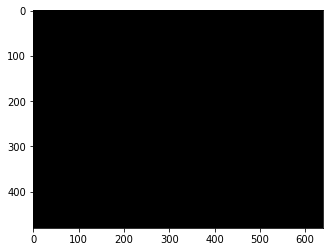

In [159]:
plt.imshow(predict_mask, cmap = "gray")

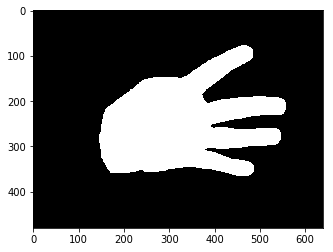

In [149]:
kernel = np.ones((10,10),np.uint8)
closing = cv2.morphologyEx(predict_mask, cv2.MORPH_OPEN, kernel)
plt.imshow(closing, cmap = "gray")

In [130]:
mask = np.zeros(shape=(len(test),len(test[0])),dtype="uint8")
mask[0,0] = 1        
pixel_hist = cv2.calcHist([test[:,:,1], test[:,:,2]], [0,1], mask, [bins,bins], [0,255,0,255])
pixel_hist = cv2.normalize(pixel_hist, pixel_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
print(pixel_hist.argmax())
#metric_val = cv2.compareHist(bidimensional_histogram, pixel_hist, cv2.HISTCMP_CHISQR)

464


In [131]:
print(int(pixel_hist.argmax() / bins), pixel_hist.argmax() % bins)

15 14


In [132]:
bidimensional_histogram[14][19]

NameError: name 'bidimensional_histogram' is not defined